## DSCI-554 Predictive Model Analysis

In this notebook, we are going to analyze the play type ("passing" or "rushing"). We know there are two types of actions taken by the offense team to either directly pass the ball or run with it. Our goal is to predict the offense play type with historic plays dataset from NFL. The data can be found at this website: https://www.kaggle.com/competitions/nfl-big-data-bowl-2023/data?select=plays.csv. The model we choose is xgboost and random forest. We will compare the performance of these two models and make further improvement on the predicted results.

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### 1. Data Preprocessing and Feature Engineering

Import the dataset and remove the quarter that is 5 since in normal game, the quarter number is less than 4. Remove downs that equal 0.

In [33]:
df = pd.read_csv('plays.csv')
df = df[~(df['quarter'] == 5)]
df = df[~(df['down'] == 0)]

We converted the gameClock from minutes to seconds, then transformed the quarter to half. For example, if the quarter number is less than or equal to 2, then it is the first half. If the quarter number is greater than 2, it is the second half.

In [34]:
def translate_game_clock(row):
    raw_game_clock = row['gameClock']
    quarter = row['quarter']
    minutes, seconds_raw = raw_game_clock.partition(':')[::2]
    seconds = seconds_raw.partition(':')[0]
    total_seconds_left_in_quarter = int(seconds) + (int(minutes) * 60)

    if quarter == 3 or quarter == 1:
        return total_seconds_left_in_quarter + 900
    elif quarter == 4 or quarter == 2:
        return total_seconds_left_in_quarter

if 'gameClock' in list (df.columns):
    df['secondsLeftInHalf'] = df.apply(translate_game_clock, axis=1)

if 'quarter' in list(df.columns):
    df['half'] = df['quarter'].map(lambda q: 2 if q > 2 else 1)

In [35]:
df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,secondsLeftInHalf,half
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,1713,1
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,...,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,1698,1
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,...,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,1643,1
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,...,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,1496,1
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,...,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,1486,1


Instead of yardlineNumber, we are more curious about the yards to the end zone so that we can know how far the offense team would go.

In [36]:
def yards_to_endzone(row):
    if row['possessionTeam'] == row['yardlineSide']:
        return 100 - row['yardlineNumber']
    else :
        return row['yardlineNumber']

df['yardsToEndzone'] = df.apply(yards_to_endzone, axis = 1)

The string value currently shown in personnel offense is not conducive to input, so we will convert each personnel position to its own column to indicate the number present on the field during the play. 

In [37]:
def transform_off_personnel(row):

    rb_count = 0
    te_count = 0
    wr_count = 0
    ol_count = 0
    dl_count = 0
    db_count = 0

    if not pd.isna(row['personnelO']):
        personnel = row['personnelO'].split(', ')
        for p in personnel:
            if p[2:4] == 'RB':
                rb_count = int(p[0])
            elif p[2:4] == 'TE':
                te_count = int(p[0])
            elif p[2:4] == 'WR':
                wr_count = int(p[0])
            elif p[2:4] == 'OL':
                ol_count = int(p[0])
            elif p[2:4] == 'DL':
                dl_count = int(p[0])
            elif p[2:4] == 'DB':
                db_count = int(p[0])

    return pd.Series([rb_count,te_count,wr_count,ol_count,dl_count, db_count])

df[['rb_count','te_count','wr_count','ol_count','dl_count', 'db_count']] = df.apply(transform_off_personnel, axis=1)

In [38]:
df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,pff_passCoverageType,secondsLeftInHalf,half,yardsToEndzone,rb_count,te_count,wr_count,ol_count,dl_count,db_count
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,Man,1713,1,67,1,1,3,0,0,0
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,...,Zone,1698,1,98,1,2,2,0,0,0
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,...,Zone,1643,1,66,0,2,3,0,0,0
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,...,Zone,1496,1,39,1,2,2,0,0,0
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,...,Zone,1486,1,44,1,1,3,0,0,0


We also encode the categorical variable offense formation into different numbers. 

In [39]:
df['offenseFormation'] = df['offenseFormation'].map(lambda f : 'EMPTY' if pd.isna(f) else f)

def formation(row):
    form = row['offenseFormation'].strip()
    if form == 'SHOTGUN':
        return 0
    elif form == 'SINGLEBACK':
        return 1
    elif form == 'EMPTY':
        return 2
    elif form == 'I_FORM':
        return 3
    elif form == 'PISTOL':
        return 4
    elif form == 'JUMBO':
        return 5
    elif form == 'WILDCAT':
        return 6
    elif form=='ACE':
        return 7
    else:
        return -1

df['numericFormation'] = df.apply(formation, axis=1)

In [40]:
df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,secondsLeftInHalf,half,yardsToEndzone,rb_count,te_count,wr_count,ol_count,dl_count,db_count,numericFormation
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,1713,1,67,1,1,3,0,0,0,0
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,...,1698,1,98,1,2,2,0,0,0,2
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,...,1643,1,66,0,2,3,0,0,0,0
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,...,1496,1,39,1,2,2,0,0,0,1
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,...,1486,1,44,1,1,3,0,0,0,0


We will convert the play outcome into a single column called play_type represented by either a 0 for running or a 1 for passing.

In [41]:
def play_type(row):
    if row['passResult'] == 'I' or row['passResult'] == 'C' or row['passResult'] == 'S':
        return 'Passing'
    else:
        return 'Rushing'

df['play_type'] = df.apply(play_type, axis = 1)
df['numericPlayType'] = df['play_type'].map(lambda p: 1 if p == 'Passing' else 0)

In [42]:
df_final = df[['down','yardsToGo', 'yardsToEndzone', 'rb_count', 'te_count', 'wr_count', 'ol_count',
               'db_count', 'secondsLeftInHalf', 'half', 'numericPlayType', 'numericFormation', 'play_type']]

The following table is the summary table of all the columns we need. Now we have done all the data preprocessing.

In [43]:
df_final.describe()

,down,yardsToGo,yardsToEndzone,rb_count,te_count,wr_count,ol_count,db_count,secondsLeftInHalf,half,numericPlayType,numericFormation
count,8424.000000,8424.000000,8424.000000,8424.000000,8424.00000,8424.000000,8424.000000,8424.0,8424.000000,8424.000000,8424.000000,8424.000000
mean,1.974953,8.752255,51.581790,1.061847,1.22151,2.700380,0.068495,0.0,795.959758,1.504511,0.924739,0.660019
std,0.865920,3.875204,23.472384,0.299348,0.54748,0.628554,0.638088,0.0,549.386974,0.500009,0.263828,1.024819
min,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000
25%,1.000000,6.000000,34.000000,1.000000,1.00000,2.000000,0.000000,0.0,280.000000,1.000000,1.000000,0.000000
50%,2.000000,10.000000,55.000000,1.000000,1.00000,3.000000,0.000000,0.0,764.000000,2.000000,1.000000,0.000000
75%,3.000000,10.000000,71.000000,1.000000,1.00000,3.000000,0.000000,0.0,1273.000000,2.000000,1.000000,1.000000
max,4.000000,39.000000,99.000000,3.000000,4.00000,5.000000,7.000000,0.0,1800.000000,2.000000,1.000000,6.000000


### 2. Data Visualization

Before introducing our predictive model, we would like to do an exploratory data analysis first. First, we draw a bar plot to see the count of the play type. From the bar plot below, we know that most play actions are passing instead of rushing. However, the number of passing is much more than that of rushing, so our label "play_type" is **imbalanced**.

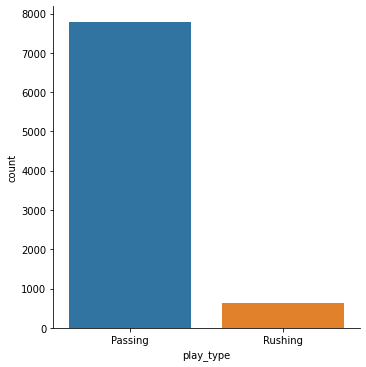

In [44]:
sns.catplot(x='play_type', kind='count', data=df_final)
plt.show()

A down is a period where a team can attempt a play. We draw a bar plot to see whether the count of play actions will change with different down. From the bar plot below, most actions are taken during the 1st, 2nd and 3rd downs. 

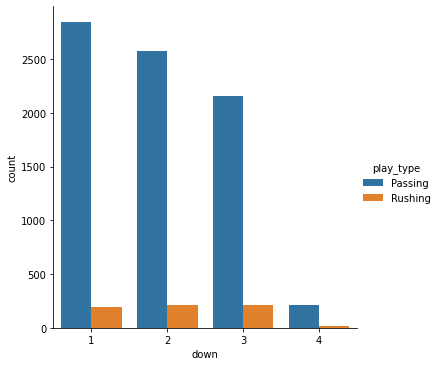

In [45]:
sns.catplot(x="down", kind="count", hue='play_type', data=df_final);
plt.show()

We draw a basic regression line to see if there is a correlation between yardsToGo and numericPlayType. From the regression line below, the larger value the yardsToGo is, the action is more prone to be rushing.

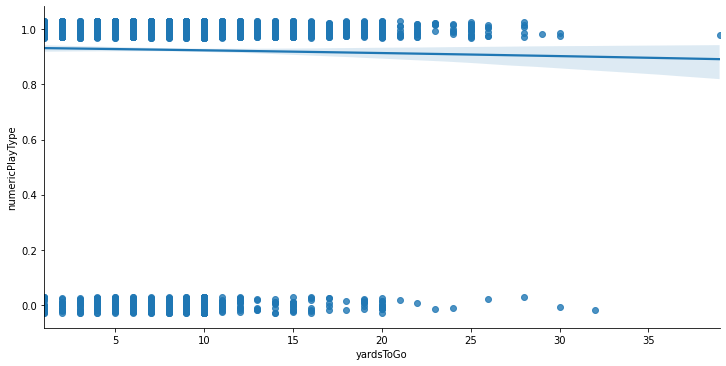

In [54]:
sns.lmplot(x="yardsToGo", y="numericPlayType", data=df_final, y_jitter=.03, logistic=True, aspect=2);
plt.show()

### 3. Predictive Model Performance Analysis

The first model we use is called random forests. The core of this model is begging which is a very powerful ensemble method. Random Forest classifier can handle both categorical and numerical variables. The input is all variables excluding the play type. We want to use all the features to predict the play actions that are taken by the players.

In [58]:
df_copy = df_final.copy()

In [59]:
df_clean = df_copy.drop(columns=['play_type'])
y = df_clean['numericPlayType']
X = df_clean.drop(columns=['numericPlayType'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [60]:
rfc=RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [61]:
y_pred = rfc.predict(X_test)

In [66]:
print("The accuracy of random forests is: " + str(accuracy_score(y_test, y_pred)))

The accuracy of random forests is: 0.9234421364985164


In [79]:
print(classification_report(y_test, y_pred))
rfc_dict = classification_report(y_test, y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       124
           1       0.93      1.00      0.96      1561

    accuracy                           0.92      1685
   macro avg       0.46      0.50      0.48      1685
weighted avg       0.86      0.92      0.89      1685



In [80]:
rfc_precision = rfc_dict['macro avg']['precision'] 
rfc_recall = rfc_dict['macro avg']['recall']    
rfc_f1 = rfc_dict['macro avg']['f1-score']
rfc_accuracy = rfc_dict['accuracy']

The second model we use is called XGBoost. XGBoosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models. It takes numerical variables and we also split the dataset into train, validation and test datasets to avoid overfitting

In [73]:
train_df, validation_df, test_df = np.split(df_final.sample(frac=1), [int(0.7 * len(df)), int(0.9 * len(df))])

train_df = train_df.drop(columns=['play_type'])
train_clean_df = train_df.drop(columns=['numericPlayType'])
d_train = xgb.DMatrix(train_clean_df, label=train_df['numericPlayType'],
                      feature_names=list(train_clean_df))


validation_df = validation_df.drop(columns=['play_type'])
val_clean_df = validation_df.drop(columns =['numericPlayType'])
d_val = xgb.DMatrix(val_clean_df, label=validation_df['numericPlayType'],
                    feature_names=list(val_clean_df))


eval_list = [(d_train, 'train'), (d_val, 'eval')]
results = {}

param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'eta': 0.2,
    'rate_drop': 0.2,
    'min_child_weight': 6,
    'gamma': 4,
    'subsample': 0.8,
    'alpha': 0.1
}

num_round = 250
xgb_model = xgb.train(param, d_train, num_round, eval_list, early_stopping_rounds=8, evals_result=results)

test_df = test_df.drop(columns=['play_type'])
test_clean_df = test_df.drop(columns=['numericPlayType'])
d_test = xgb.DMatrix(test_clean_df, label=test_df['numericPlayType'],
                     feature_names=list(test_clean_df))


true = test_df['numericPlayType']
pred = xgb_model.predict(d_test)

[02:13:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	eval-auc:0.50000
[1]	train-auc:0.50000	eval-auc:0.50000
[2]	train-auc:0.50000	eval-auc:0.50000
[3]	train-auc:0.55653	eval-auc:0.52245
[4]	train-auc:0.55653	eval-auc:0.52245
[5]	train-auc:0.55653	eval-auc:0.52245
[6]	train-auc:0.55653	eval-auc:0.52245
[7]	train-auc:0.56775	eval-auc:0.53645
[8]	train-auc:0.56775	eval-auc:0.53645
[9]	train-auc:0.58330	eval-auc:0.54968
[10]	train-auc:0.60170	eval-auc:0.54744
[11]	train-auc:0.59032	eval-auc:0.55703
[12]	train-auc:0.61958	eval-auc:0.56049
[13]	train-auc:0.62864	eval-auc:0.56976
[14]	train-a

In [74]:
accuracy = accuracy_score(true, np.round(pred))
print("The accuracy of XGBoost is: " + str(accuracy))

The accuracy of XGBoost is: 0.9157769869513642


In [89]:
print(classification_report(true, np.round(pred)))
xgb_dict = classification_report(true, np.round(pred), output_dict=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.92      1.00      0.96       772

    accuracy                           0.92       843
   macro avg       0.46      0.50      0.48       843
weighted avg       0.84      0.92      0.88       843



In [90]:
xgb_precision = xgb_dict['macro avg']['precision'] 
xgb_recall = xgb_dict['macro avg']['recall']    
xgb_f1 = xgb_dict['macro avg']['f1-score']
xgb_accuracy = xgb_dict['accuracy']

Now we create a dataframe to summarize the performance of these two models by calculating their precision, recall, f1-score and accuracy respectively.

In [91]:
data = [[rfc_precision, rfc_recall, rfc_f1, rfc_accuracy], [xgb_precision, xgb_recall, xgb_f1, xgb_accuracy]]
df = pd.DataFrame(data, columns=['precision', 'recall', 'f1-score', 'accuracy'], index=['rfc', 'xgb'])
df

,precision,recall,f1-score,accuracy
rfc,0.463095,0.498398,0.480099,0.923442
xgb,0.457888,0.500000,0.478019,0.915777


The precision is from all the classes we have predicted as positive, how many are actually positive. It should be as high as possible. And the recall is from all the positive classes, how many we predicted correctly. It also should be as high as possible. The f1-score compares precision and recall at the same time. It uses harmonic mean to integrate precision and recall. The accuracy is from all classes, how many of them we have predicted correctly. Higher accuracy sometimes means better model performance (we should avoid overfitting). Overall, random forests classifier performs better than XGBoost, but the results are very close. Thus, in our predictive model analysis, either random forests and XGBoost are good to predict the play type (passing or rushing).